In [1]:
# Importar librerías necesarias
import pandas as pd #data processing
import numpy as np ##linear algebra
import requests

import csv
from pandas import DataFrame ## reading data as tables
import matplotlib.pyplot as plt
import seaborn as sns

import IPython.display as display
from IPython.display import HTML



import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

##  Time series analysis:  

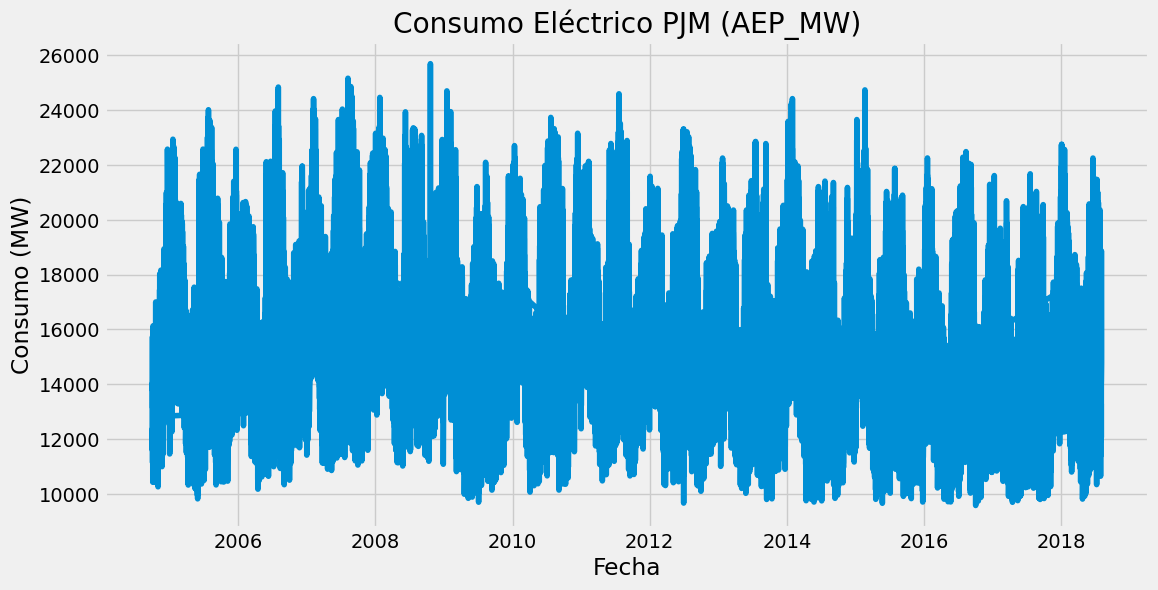

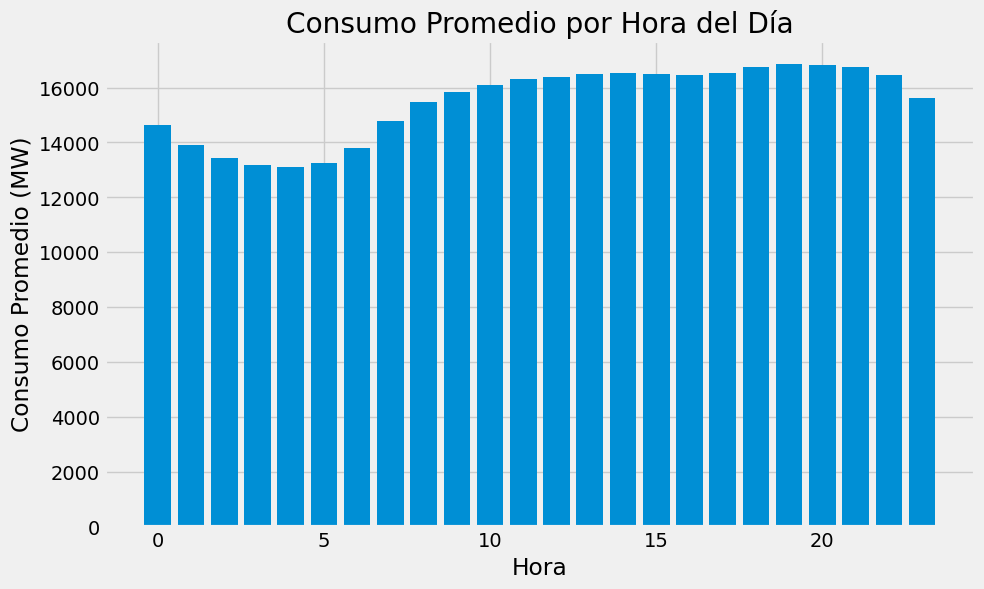

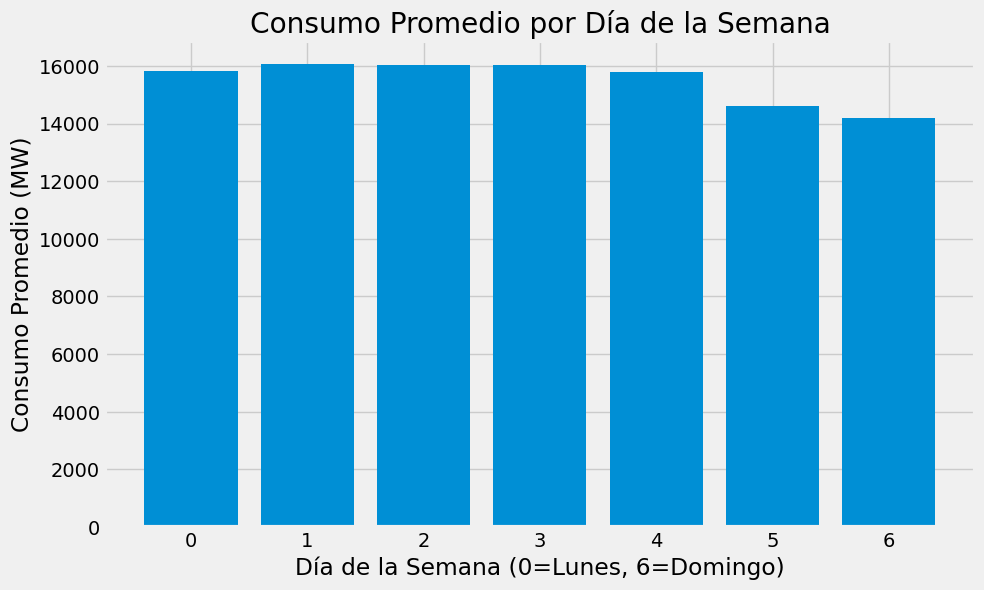

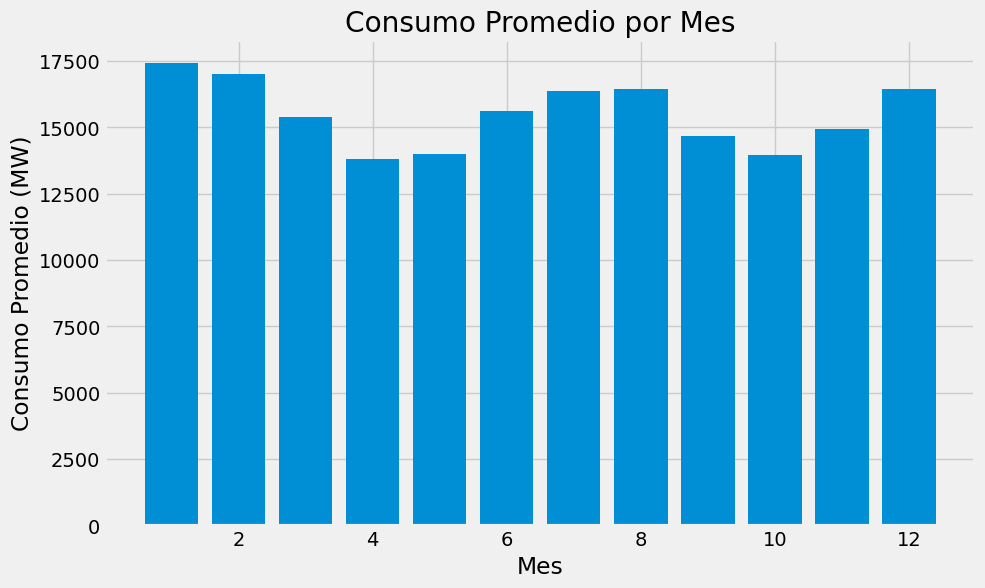

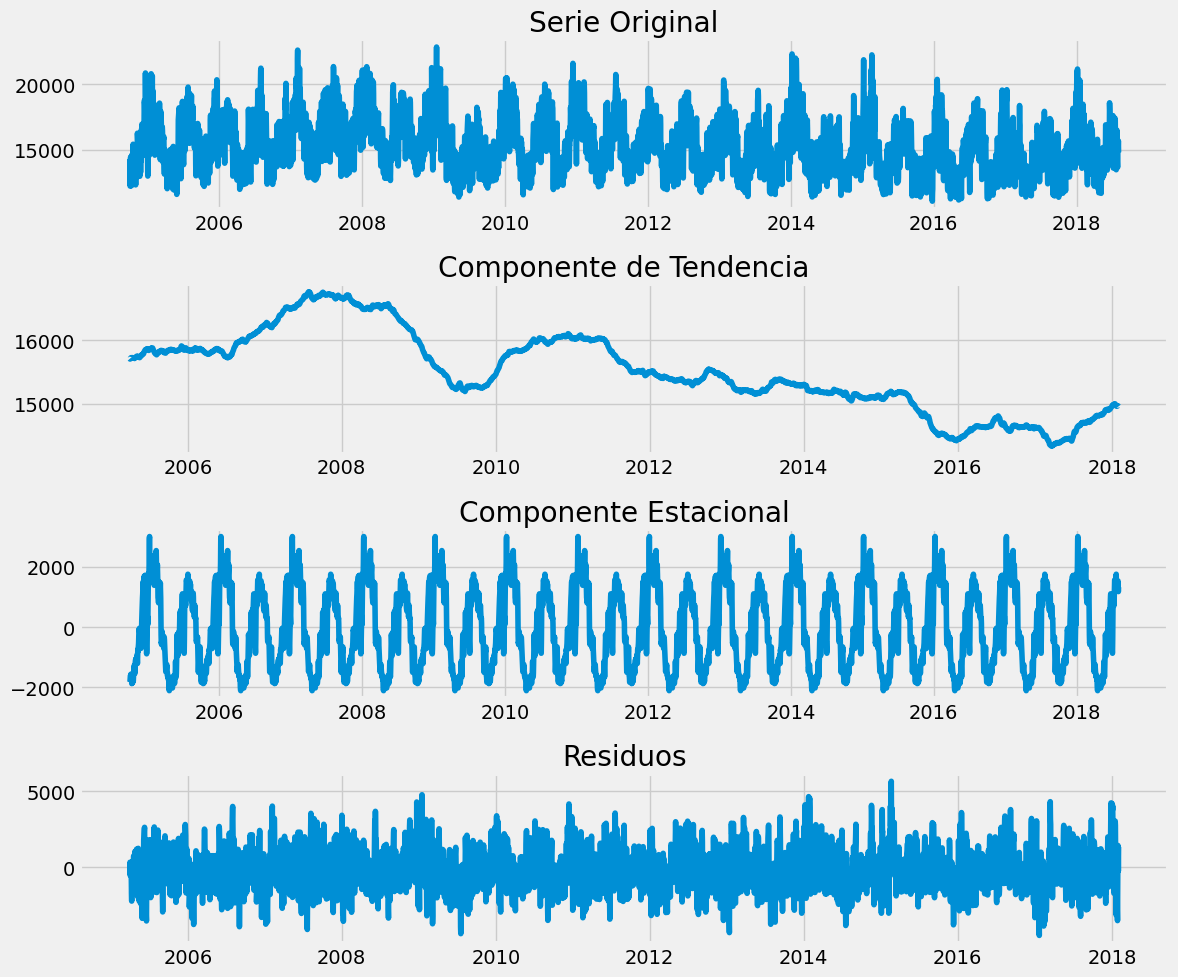

Análisis de la Serie Temporal:
- Período: 2004-10-01 01:00:00 a 2018-08-03 00:00:00
- Número de observaciones: 121273

Patrones identificados:
- Hora con mayor consumo promedio: 19 (16868.73 MW)
- Día de la semana con mayor consumo: 1 (16057.62 MW)
- Mes con mayor consumo: 1 (17431.27 MW)


In [2]:
from statsmodels.tsa.seasonal import seasonal_decompose


# Cargar el dataset
df = pd.read_csv('/content/drive/MyDrive/MachineLearningAvanzado/sumsion2/AEP_hourly.csv')

df['Datetime'] = pd.to_datetime(df['Datetime'])
df = df.set_index('Datetime')

# Visualización básica de la serie completa
plt.figure(figsize=(12, 6))
plt.plot(df['AEP_MW'])
plt.title('Consumo Eléctrico PJM (AEP_MW)')
plt.xlabel('Fecha')
plt.ylabel('Consumo (MW)')
plt.grid(True)
plt.show()

# Usar tu función create_features para desglosar las características temporales
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week

    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

# Aplicar la función a todo el dataset para análisis
X_features, y_target = create_features(df, label='AEP_MW')

# Analizar patrones por hora del día
hourly_avg = df.groupby(df.index.hour)['AEP_MW'].mean()
plt.figure(figsize=(10, 6))
plt.bar(hourly_avg.index, hourly_avg.values)
plt.title('Consumo Promedio por Hora del Día')
plt.xlabel('Hora')
plt.ylabel('Consumo Promedio (MW)')
plt.grid(True, axis='y')
plt.show()

# Analizar patrones por día de la semana
dow_avg = df.groupby(df.index.dayofweek)['AEP_MW'].mean()
plt.figure(figsize=(10, 6))
plt.bar(dow_avg.index, dow_avg.values)
plt.title('Consumo Promedio por Día de la Semana')
plt.xlabel('Día de la Semana (0=Lunes, 6=Domingo)')
plt.ylabel('Consumo Promedio (MW)')
plt.grid(True, axis='y')
plt.show()

# Analizar patrones por mes
monthly_avg = df.groupby(df.index.month)['AEP_MW'].mean()
plt.figure(figsize=(10, 6))
plt.bar(monthly_avg.index, monthly_avg.values)
plt.title('Consumo Promedio por Mes')
plt.xlabel('Mes')
plt.ylabel('Consumo Promedio (MW)')
plt.grid(True, axis='y')
plt.show()

# Descomposición de la serie temporal
# Usar datos diarios para una mejor visualización
df_daily = df.resample('D').mean()
result = seasonal_decompose(df_daily['AEP_MW'], model='additive', period=365)

# Visualizar los componentes de la descomposición
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 10))

ax1.plot(result.observed)
ax1.set_title('Serie Original')
ax1.grid(True)

ax2.plot(result.trend)
ax2.set_title('Componente de Tendencia')
ax2.grid(True)

ax3.plot(result.seasonal)
ax3.set_title('Componente Estacional')
ax3.grid(True)

ax4.plot(result.resid)
ax4.set_title('Residuos')
ax4.grid(True)

plt.tight_layout()
plt.show()

# Agregar interpretación básica
print("Análisis de la Serie Temporal:")
print(f"- Período: {df.index.min()} a {df.index.max()}")
print(f"- Número de observaciones: {len(df)}")
print("\nPatrones identificados:")
print(f"- Hora con mayor consumo promedio: {hourly_avg.idxmax()} ({hourly_avg.max():.2f} MW)")
print(f"- Día de la semana con mayor consumo: {dow_avg.idxmax()} ({dow_avg.max():.2f} MW)")
print(f"- Mes con mayor consumo: {monthly_avg.idxmax()} ({monthly_avg.max():.2f} MW)")

## ARMA

Resultado de la prueba Dickey-Fuller Aumentada:
Estadístico ADF: -16.44681210468681
Valor p: 2.399011324001736e-29
Valores críticos:
   1%: -3.430403955318047
   5%: -2.8615638474512295
   10%: -2.566782693155802
La serie es estacionaria (rechazamos la hipótesis nula)
Resultado de la prueba Dickey-Fuller Aumentada:
Estadístico ADF: -45.05152316790342
Valor p: 0.0
Valores críticos:
   1%: -3.430403955763232
   5%: -2.861563847647993
   10%: -2.566782693260533
La serie es estacionaria (rechazamos la hipótesis nula)


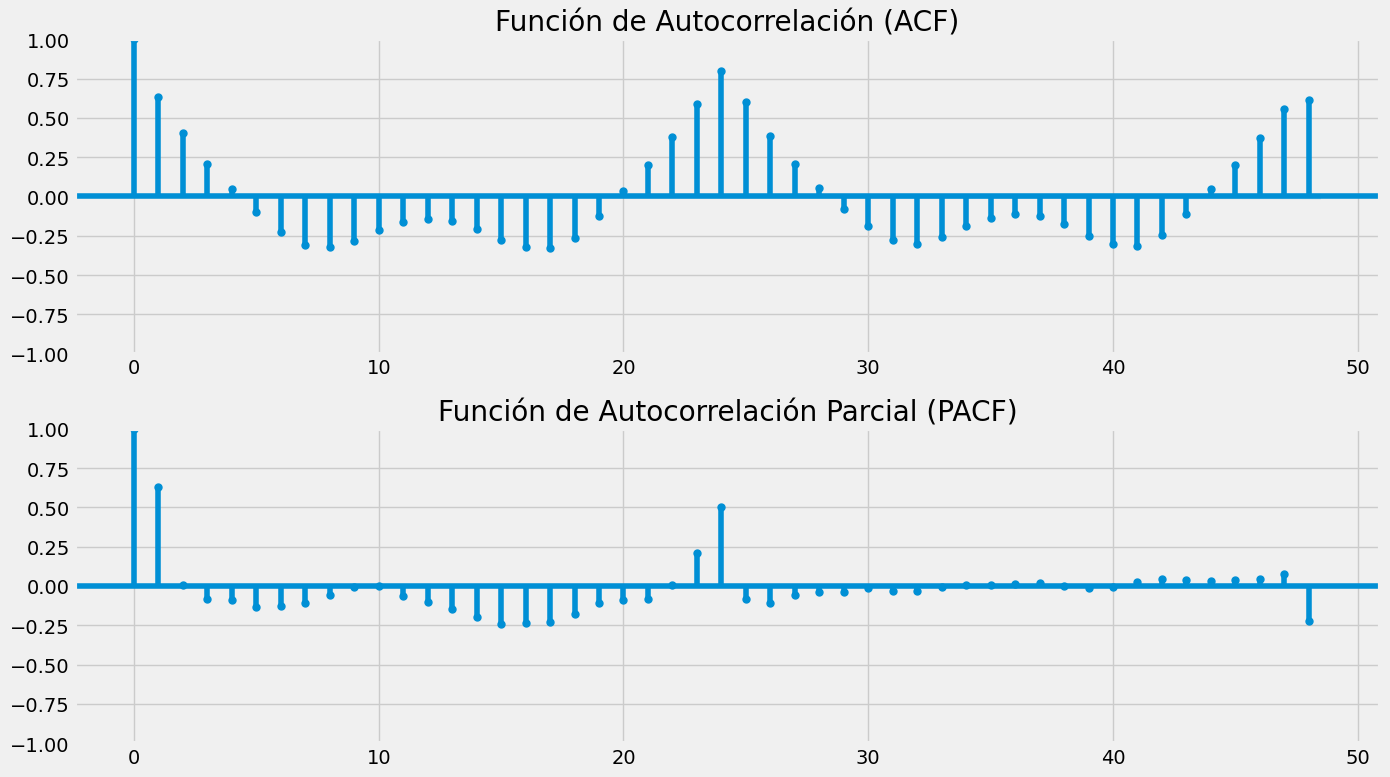

                               SARIMAX Results                                
Dep. Variable:                 AEP_MW   No. Observations:               121273
Model:                 ARIMA(2, 1, 2)   Log Likelihood             -915739.132
Date:                Fri, 25 Apr 2025   AIC                        1831488.264
Time:                        14:21:22   BIC                        1831536.793
Sample:                             0   HQIC                       1831502.865
                             - 121273                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7303      0.002    793.075      0.000       1.726       1.735
ar.L2         -0.8183      0.002   -370.177      0.000      -0.823      -0.814
ma.L1         -1.2562      0.003   -460.113      0.0

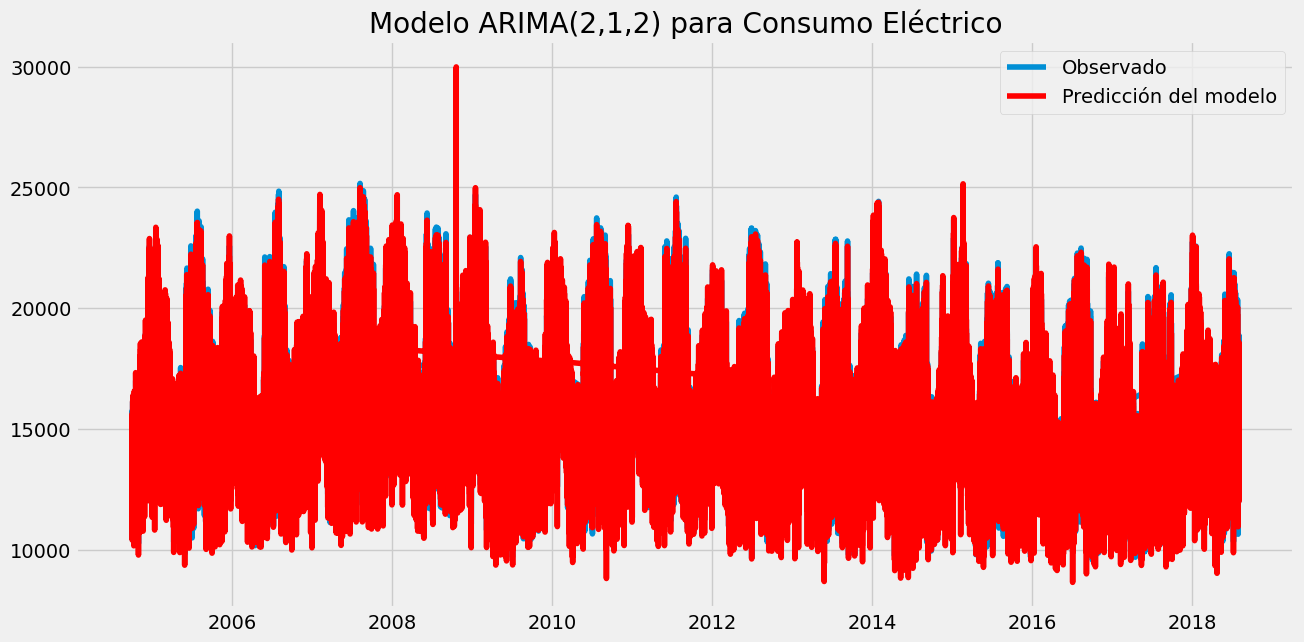

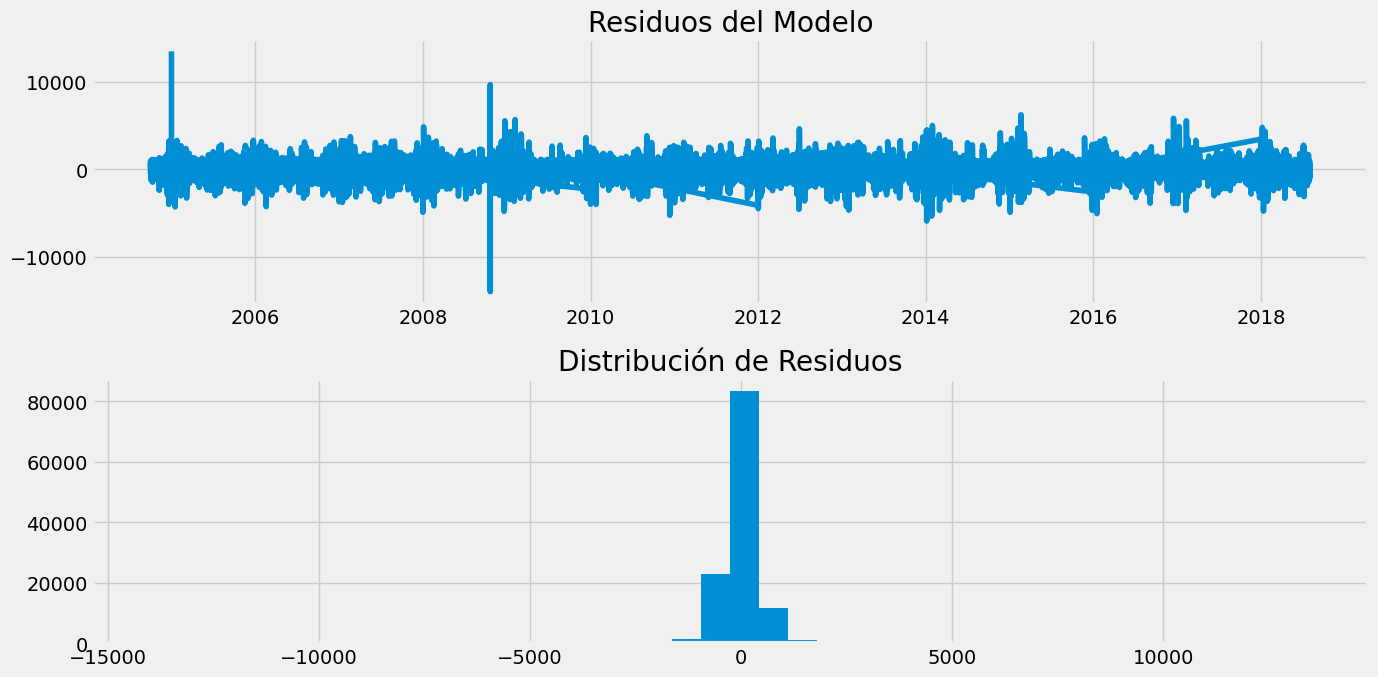

MAE: 301.42
RMSE: 460.39
MAPE: 1.99%


In [3]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings('ignore')




# 1. Verificar estacionariedad
def test_stationarity(timeseries):
    # Prueba Dickey-Fuller Aumentada
    result = adfuller(timeseries.dropna())
    print('Resultado de la prueba Dickey-Fuller Aumentada:')
    print(f'Estadístico ADF: {result[0]}')
    print(f'Valor p: {result[1]}')
    print(f'Valores críticos:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')

    # Interpretación
    if result[1] <= 0.05:
        print("La serie es estacionaria (rechazamos la hipótesis nula)")
    else:
        print("La serie no es estacionaria (no podemos rechazar la hipótesis nula)")

# Verificar estacionariedad de la serie original
test_stationarity(df['AEP_MW'])

# 2. Diferenciar la serie para hacerla estacionaria (si es necesario)
# Diferenciación regular
df_diff = df['AEP_MW'].diff().dropna()

# Verificar estacionariedad después de la diferenciación
test_stationarity(df_diff)

# 3. Generar gráficos ACF y PACF para identificar órdenes p y q
plt.figure(figsize=(14, 8))
plt.subplot(211)
plot_acf(df_diff, ax=plt.gca(), lags=48)
plt.title('Función de Autocorrelación (ACF)')

plt.subplot(212)
plot_pacf(df_diff, ax=plt.gca(), lags=48)
plt.title('Función de Autocorrelación Parcial (PACF)')
plt.tight_layout()
plt.show()

# 4. Ajustar modelo ARMA (o ARIMA si se requiere diferenciación)
# Nota: Si necesitaste diferenciar, estás ajustando un modelo ARIMA con d=1
# ARMA(p,q) es equivalente a ARIMA(p,0,q)

# Basado en los gráficos ACF y PACF, selecciona los órdenes p y q
# Este es un ejemplo - ajusta estos parámetros según tus resultados
p = 2  # Orden autoregresivo
d = 1  # Orden de diferenciación (1 porque diferenciamos una vez)
q = 2  # Orden de media móvil

# Ajustar el modelo
model = ARIMA(df['AEP_MW'], order=(p, d, q))
results = model.fit()

# 5. Mostrar resumen del modelo
print(results.summary())

# 6. Realizar pronóstico dentro de la muestra para evaluar el ajuste
pred = results.predict(start=df.index[p+d], end=df.index[-1])

# 7. Visualizar resultados
plt.figure(figsize=(14, 7))
plt.plot(df['AEP_MW'], label='Observado')
plt.plot(pred, label='Predicción del modelo', color='red')
plt.title(f'Modelo ARIMA({p},{d},{q}) para Consumo Eléctrico')
plt.legend()
plt.grid(True)
plt.show()

# 8. Evaluar residuos
residuals = results.resid
plt.figure(figsize=(14, 7))

plt.subplot(211)
plt.plot(residuals)
plt.title('Residuos del Modelo')
plt.grid(True)

plt.subplot(212)
plt.hist(residuals, bins=40)
plt.title('Distribución de Residuos')
plt.grid(True)

plt.tight_layout()
plt.show()

# 9. Calcular métricas de rendimiento
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(df['AEP_MW'][p+d:], pred)
rmse = np.sqrt(mean_squared_error(df['AEP_MW'][p+d:], pred))
mape = np.mean(np.abs((df['AEP_MW'][p+d:] - pred) / df['AEP_MW'][p+d:])) * 100

print(f'MAE: {mae:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'MAPE: {mape:.2f}%')

## ARIMA (General modeling procedure)

Datos de entrenamiento: 120554 observaciones, de 2004-12-31 01:00:00 a 2018-01-30 01:00:00
Datos de prueba: 720 observaciones, de 2018-01-30 01:00:00 a 2018-01-02 00:00:00

=== Comparación de Modelos ARIMA ===

Métricas dentro de la muestra:
ARIMA(1,1,1): MAE=320.46, RMSE=491.80, MAPE=2.13%
ARIMA(2,1,2): MAE=300.99, RMSE=459.07, MAPE=1.99%
ARIMA(3,1,3): MAE=292.29, RMSE=447.37, MAPE=1.94%

Métricas de pronóstico (24 horas):
ARIMA(1,1,1): MAE=1330.84, RMSE=1487.39, MAPE=nan%
ARIMA(2,1,2): MAE=1239.60, RMSE=1354.24, MAPE=nan%
ARIMA(3,1,3): MAE=1184.84, RMSE=1555.23, MAPE=nan%


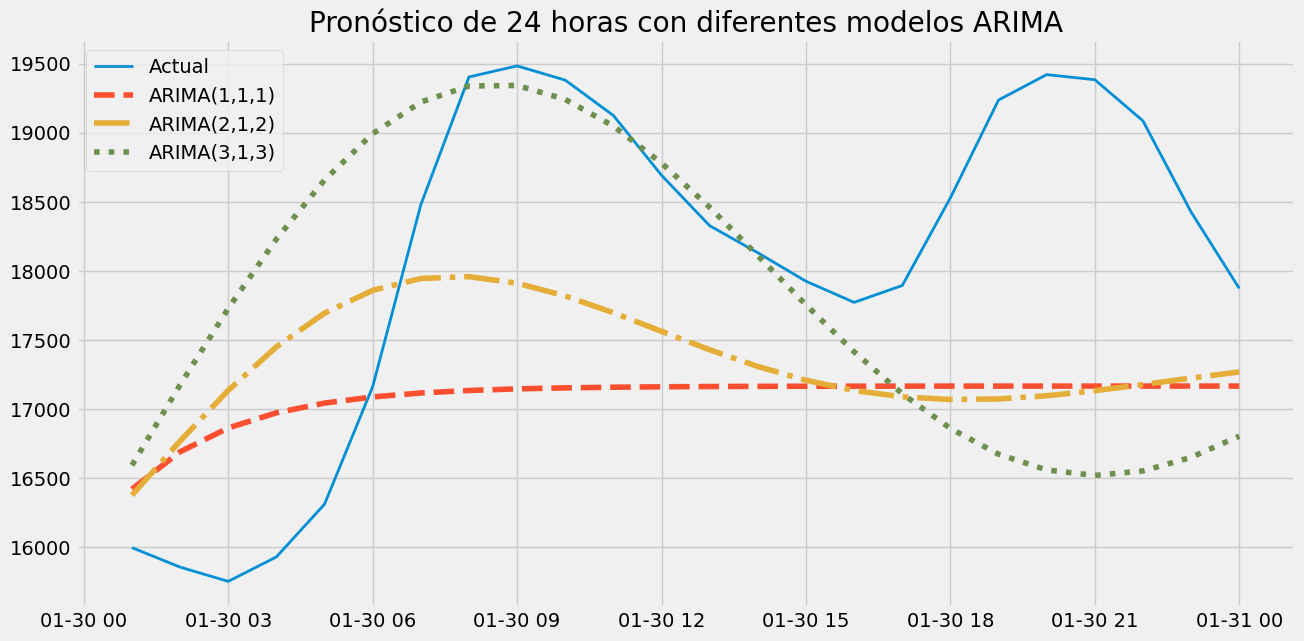

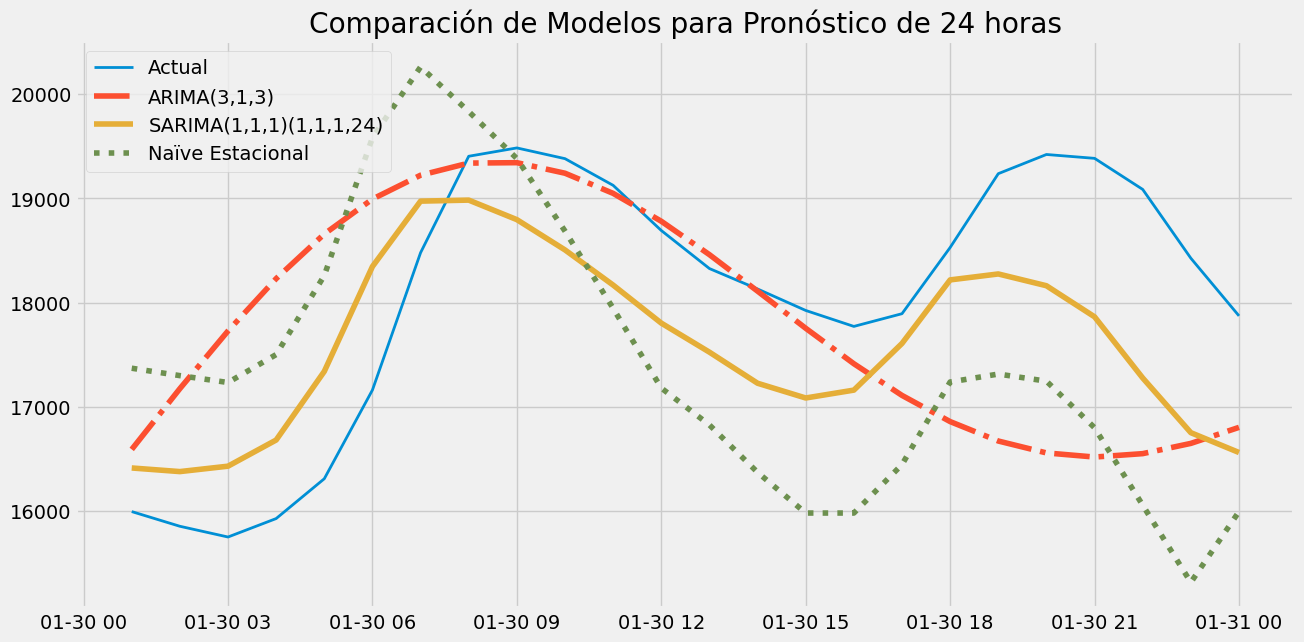

In [4]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')
# Función para evaluar modelos ARIMA
def evaluate_arima_model(p, d, q, train_data, test_data=None):
    """
    Ajusta un modelo ARIMA y evalúa su rendimiento
    """
    # Ajustar modelo
    model = ARIMA(train_data, order=(p, d, q))
    results = model.fit()

    # Hacer predicciones dentro de la muestra
    predictions = results.predict(start=p+d, end=len(train_data)-1)

    # Calcular métricas dentro de la muestra
    mae = mean_absolute_error(train_data[p+d:], predictions)
    rmse = np.sqrt(mean_squared_error(train_data[p+d:], predictions))
    mape = np.mean(np.abs((train_data[p+d:] - predictions) / train_data[p+d:])) * 100

    # Si hay datos de prueba, hacer predicciones fuera de muestra
    if test_data is not None:
        # Predecir los primeros 24 valores (1 día) del conjunto de prueba
        forecast_steps = 24
        forecast = results.forecast(steps=forecast_steps)

        # Calcular métricas de pronóstico
        forecast_mae = mean_absolute_error(test_data[:forecast_steps], forecast)
        forecast_rmse = np.sqrt(mean_squared_error(test_data[:forecast_steps], forecast))
        forecast_mape = np.mean(np.abs((test_data[:forecast_steps] - forecast) / test_data[:forecast_steps])) * 100

        return results, mae, rmse, mape, forecast, forecast_mae, forecast_rmse, forecast_mape

    return results, mae, rmse, mape

# Dividir datos en entrenamiento y prueba (últimos 30 días para prueba)
train_end = df.index[-30*24]  # 30 días x 24 horas
df_train = df.loc[:train_end]
df_test = df.loc[train_end:]

print(f"Datos de entrenamiento: {len(df_train)} observaciones, de {df_train.index[0]} a {df_train.index[-1]}")
print(f"Datos de prueba: {len(df_test)} observaciones, de {df_test.index[0]} a {df_test.index[-1]}")

# Vamos a probar diferentes combinaciones de p y q, manteniendo d=1
# Modelo 1: ARIMA(1,1,1) - más simple
model1_results, model1_mae, model1_rmse, model1_mape, model1_forecast, model1_f_mae, model1_f_rmse, model1_f_mape = evaluate_arima_model(1, 1, 1, df_train['AEP_MW'], df_test['AEP_MW'])

# Modelo 2: ARIMA(2,1,2) - el que ya has probado
model2_results, model2_mae, model2_rmse, model2_mape, model2_forecast, model2_f_mae, model2_f_rmse, model2_f_mape = evaluate_arima_model(2, 1, 2, df_train['AEP_MW'], df_test['AEP_MW'])

# Modelo 3: ARIMA(3,1,3) - más complejo
model3_results, model3_mae, model3_rmse, model3_mape, model3_forecast, model3_f_mae, model3_f_rmse, model3_f_mape = evaluate_arima_model(3, 1, 3, df_train['AEP_MW'], df_test['AEP_MW'])

# Imprimir resumen de resultados
print("\n=== Comparación de Modelos ARIMA ===")
print("\nMétricas dentro de la muestra:")
print(f"ARIMA(1,1,1): MAE={model1_mae:.2f}, RMSE={model1_rmse:.2f}, MAPE={model1_mape:.2f}%")
print(f"ARIMA(2,1,2): MAE={model2_mae:.2f}, RMSE={model2_rmse:.2f}, MAPE={model2_mape:.2f}%")
print(f"ARIMA(3,1,3): MAE={model3_mae:.2f}, RMSE={model3_rmse:.2f}, MAPE={model3_mape:.2f}%")

print("\nMétricas de pronóstico (24 horas):")
print(f"ARIMA(1,1,1): MAE={model1_f_mae:.2f}, RMSE={model1_f_rmse:.2f}, MAPE={model1_f_mape:.2f}%")
print(f"ARIMA(2,1,2): MAE={model2_f_mae:.2f}, RMSE={model2_f_rmse:.2f}, MAPE={model2_f_mape:.2f}%")
print(f"ARIMA(3,1,3): MAE={model3_f_mae:.2f}, RMSE={model3_f_rmse:.2f}, MAPE={model3_f_mape:.2f}%")

# Visualizar los pronósticos de los tres modelos
plt.figure(figsize=(14, 7))
plt.plot(df_test.index[:24], df_test['AEP_MW'][:24], label='Actual', linewidth=2)
plt.plot(df_test.index[:24], model1_forecast, label='ARIMA(1,1,1)', linestyle='--')
plt.plot(df_test.index[:24], model2_forecast, label='ARIMA(2,1,2)', linestyle='-.')
plt.plot(df_test.index[:24], model3_forecast, label='ARIMA(3,1,3)', linestyle=':')
plt.title('Pronóstico de 24 horas con diferentes modelos ARIMA')
plt.legend()
plt.grid(True)
plt.show()


# Enfoque con SARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Reducir los datos para un ajuste más rápido si es necesario
train_short = df_train['AEP_MW'][-7*24:]  # Últimos 7 días

# Modelo SARIMA básico con estacionalidad diaria (24 horas)
model_sarima = SARIMAX(train_short,
                     order=(1, 1, 1),
                     seasonal_order=(1, 1, 1, 24))
sarima_results = model_sarima.fit(disp=False)

# Hacer pronóstico con SARIMA
sarima_forecast = sarima_results.forecast(steps=24)

# Enfoque naïve estacional (usar valores de hace 24 horas)
naive_seasonal_forecast = df_train['AEP_MW'][-24:].values

# Graficar comparación
plt.figure(figsize=(14, 7))
plt.plot(df_test.index[:24], df_test['AEP_MW'][:24], label='Actual', linewidth=2)
plt.plot(df_test.index[:24], model3_forecast, label='ARIMA(3,1,3)', linestyle='-.')
plt.plot(df_test.index[:24], sarima_forecast, label='SARIMA(1,1,1)(1,1,1,24)', linestyle='-')
plt.plot(df_test.index[:24], naive_seasonal_forecast, label='Naïve Estacional', linestyle=':')
plt.title('Comparación de Modelos para Pronóstico de 24 horas')
plt.legend()
plt.grid(True)
plt.show()

## SARIMA (General modeling procedure adapted for SARIMA)


Datos de entrenamiento: 2160 observaciones
Datos de prueba: 168 observaciones
Ajustando SARIMA(1,1,1)(1,1,1,24)...
Resultados SARIMA(1,1,1)(1,1,1,24):
MAE: 2084.97
RMSE: 2548.36
MAPE: nan%


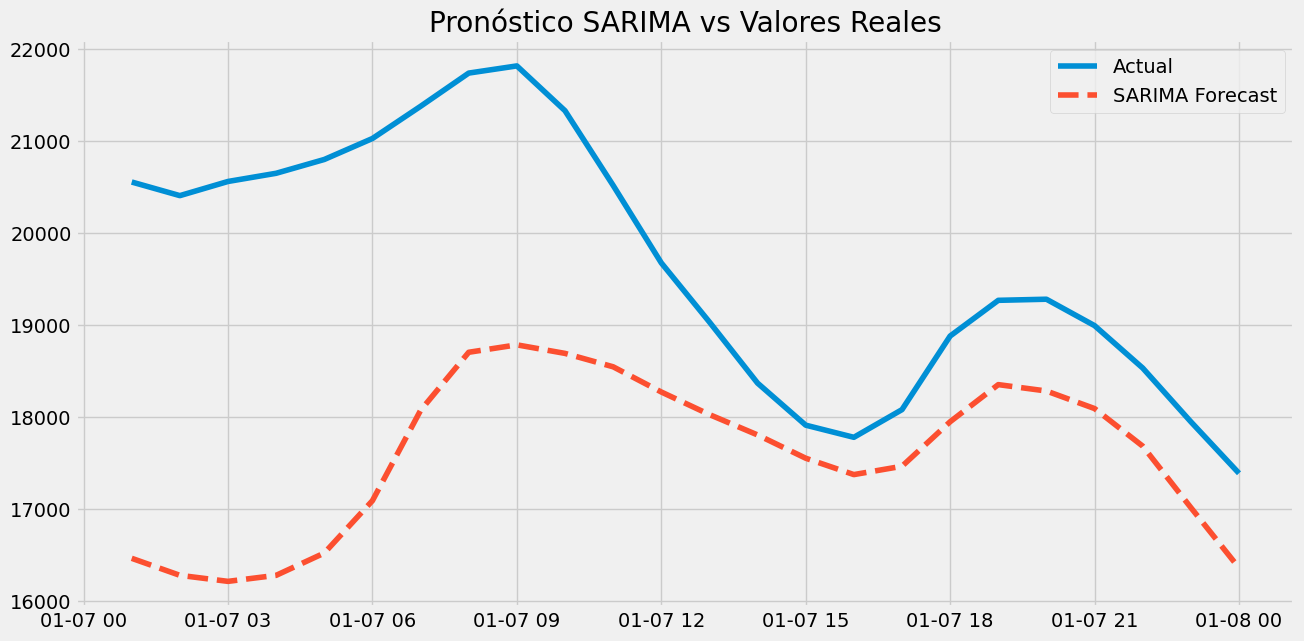

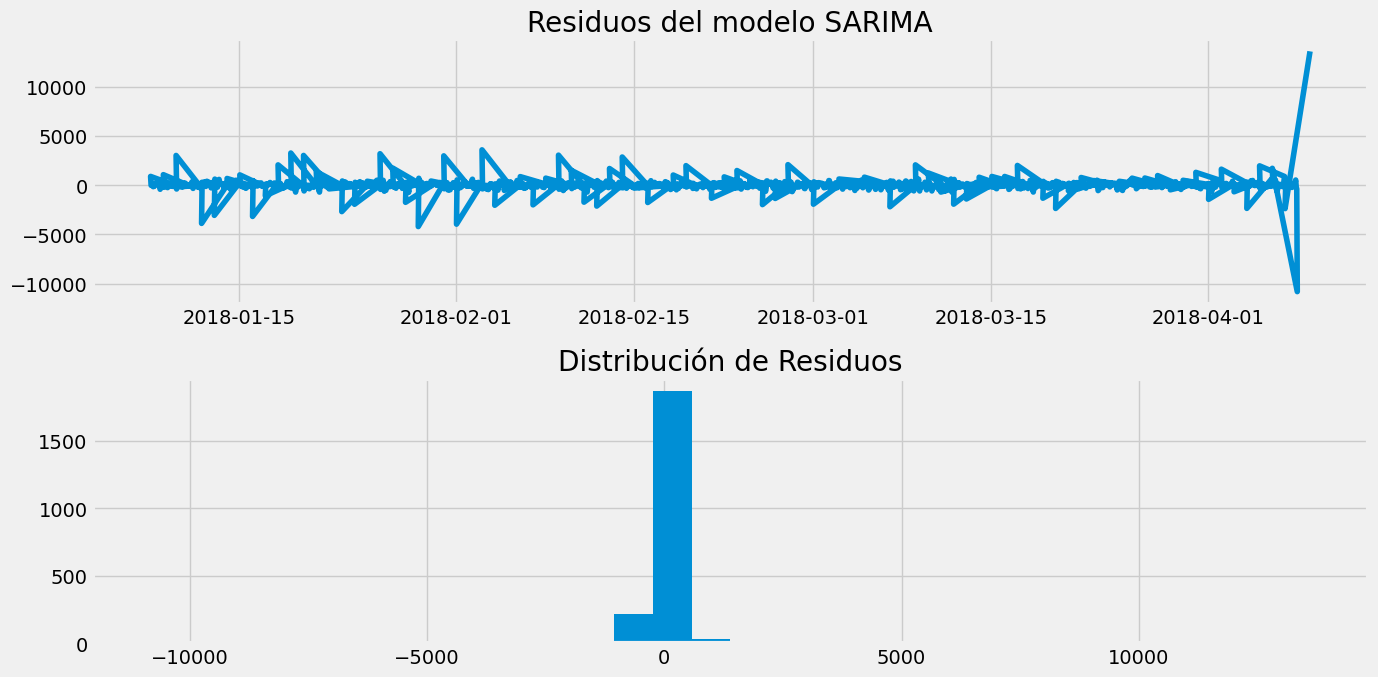

In [5]:

# Usar un subconjunto de datos más pequeño para evitar problemas de cómputo
# Tomamos los últimos 90 días para entrenamiento y los últimos 7 días para prueba
train_days = 90
test_days = 7

# Dividir datos
df_short = df.iloc[-((train_days + test_days) * 24):]
split_point = -test_days * 24
df_train = df_short.iloc[:split_point]
df_test = df_short.iloc[split_point:]

print(f"Datos de entrenamiento: {len(df_train)} observaciones")
print(f"Datos de prueba: {len(df_test)} observaciones")

# Modelo SARIMA simplificado
try:
    print("Ajustando SARIMA(1,1,1)(1,1,1,24)...")
    model = SARIMAX(df_train['AEP_MW'],
                   order=(1, 1, 1),
                   seasonal_order=(1, 1, 1, 24),
                   enforce_stationarity=False,
                   enforce_invertibility=False)

    # Ajuste con un número máximo de iteraciones reducido
    results = model.fit(disp=False, maxiter=50)

    # Generar pronóstico para 24 horas
    forecast = results.forecast(steps=24)

    # Calcular métricas
    mae = mean_absolute_error(df_test['AEP_MW'][:24], forecast)
    rmse = np.sqrt(mean_squared_error(df_test['AEP_MW'][:24], forecast))
    mape = np.mean(np.abs((df_test['AEP_MW'][:24] - forecast) / df_test['AEP_MW'][:24])) * 100

    print(f"Resultados SARIMA(1,1,1)(1,1,1,24):")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAPE: {mape:.2f}%")

    # Gráfico del pronóstico
    plt.figure(figsize=(14, 7))
    plt.plot(df_test.index[:24], df_test['AEP_MW'][:24], label='Actual')
    plt.plot(df_test.index[:24], forecast, label='SARIMA Forecast', linestyle='--')
    plt.title('Pronóstico SARIMA vs Valores Reales')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Análisis de residuos
    plt.figure(figsize=(14, 7))

    # Residuos vs tiempo
    plt.subplot(2, 1, 1)
    residuals = results.resid
    plt.plot(residuals)
    plt.title('Residuos del modelo SARIMA')
    plt.grid(True)

    # Histograma de residuos
    plt.subplot(2, 1, 2)
    plt.hist(residuals, bins=30)
    plt.title('Distribución de Residuos')
    plt.grid(True)

    plt.tight_layout()
    plt.show()



except Exception as e:
    print(f"Error al ajustar SARIMA: {e}")

    # Plan alternativo: implementar un modelo SARIMA más simple o un enfoque estacional alternativo
    print("\nImplementando enfoque alternativo para estacionalidad...")

    # Método 1: Descomposición + ARIMA en componentes
    from statsmodels.tsa.seasonal import seasonal_decompose

    # Descomponer la serie en tendencia, estacionalidad y residuo
    decomposition = seasonal_decompose(df_train['AEP_MW'], model='additive', period=24)

    trend = decomposition.trend.dropna()
    seasonal = decomposition.seasonal
    residual = decomposition.resid.dropna()

    # Modelar la tendencia con ARIMA
    trend_model = ARIMA(trend, order=(1, 1, 1))
    trend_fit = trend_model.fit()

    # Pronosticar tendencia
    trend_forecast = trend_fit.forecast(steps=24)

    # Añadir la estacionalidad del día correspondiente
    seasonal_part = seasonal.iloc[-24:].values

    # Combinar para formar el pronóstico final
    final_forecast = trend_forecast + seasonal_part

    # Calcular métricas
    decomp_mae = mean_absolute_error(df_test['AEP_MW'][:24], final_forecast)
    decomp_rmse = np.sqrt(mean_squared_error(df_test['AEP_MW'][:24], final_forecast))
    decomp_mape = np.mean(np.abs((df_test['AEP_MW'][:24] - final_forecast) / df_test['AEP_MW'][:24])) * 100

    print(f"\nResultados del enfoque de descomposición:")
    print(f"MAE: {decomp_mae:.2f}")
    print(f"RMSE: {decomp_rmse:.2f}")
    print(f"MAPE: {decomp_mape:.2f}%")

    # Visualizar
    plt.figure(figsize=(14, 7))
    plt.plot(df_test.index[:24], df_test['AEP_MW'][:24], label='Actual')
    plt.plot(df_test.index[:24], final_forecast, label='Descomp. + ARIMA', linestyle='--')
    plt.title('Pronóstico con Descomposición Estacional')
    plt.legend()
    plt.grid(True)
    plt.show()